In [1]:
from qiskit import *
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

A combination of X and CX gates form a balance function. A sequence of these gates can be used for generating a quantum oracle for the balanced function. Having no such sequence implies that the function being constructed is constant. invertY=True inverts the 2nd register, effectively inverting the output for every state.

In [2]:
# 0 for identity, 1 for cx, 2 for X CX X
# initialize y qbit with + or - state
def create_oracle(oracleStr,invertY):
    n = len(oracleStr)
    f = QuantumCircuit(n+1)
    flippers = QuantumCircuit(n+1)
    oracle = QuantumCircuit(n+1)
    if invertY:
        oracle.x(n)
    for qbit in range(n):
        if int(oracleStr[qbit])>0:
            f.cx(qbit,n)
        if int(oracleStr[qbit])>1:
            flippers.x(qbit)
    f.barrier()
    flippers.barrier()
    return oracle.compose(flippers).compose(f).compose(flippers)

The function below puts together the initialization, the oracle and
and measurement

In [3]:
def create_dj(oracleStr,invertY):
    n = len(oracleStr)
    dj = QuantumCircuit(n+1,n)
    for qbit in range(n):
        dj.h(qbit)
    dj.x(n)
    dj.h(n)
    dj.barrier()
    dj.compose(create_oracle(oracleStr,invertY),inplace=True)

    for qbit in range(n):
        dj.h(qbit)
    dj.barrier()
    dj.measure(range(n),range(n))
    return dj

In [4]:
def runBackend(qc,backend):
    qobj = transpile(qc,backend,optimization_level=3)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

In [5]:
def runAer(qc):
    return runBackend(qc,Aer.get_backend('aer_simulator'))

In [6]:
def runReal(qc,n):
    provider = IBMQ.get_provider('ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >=n and x.name()!='ibmq_bogota'  and 
                                        not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    return runBackend(qc,backend)

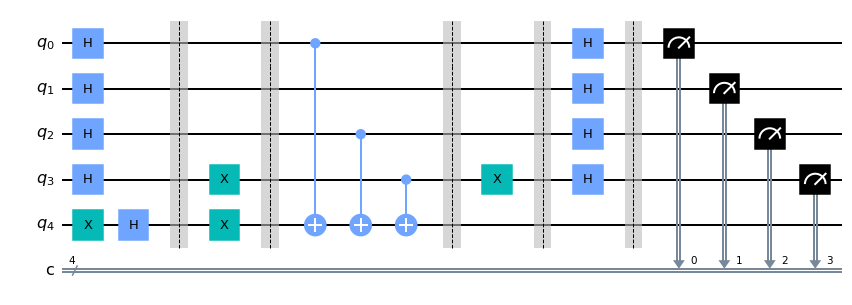

In [7]:
s = '1012'
invY=True
dj = create_dj(s,invY)
n=len(s)
dj.draw('mpl')

Job Status: job has successfully run


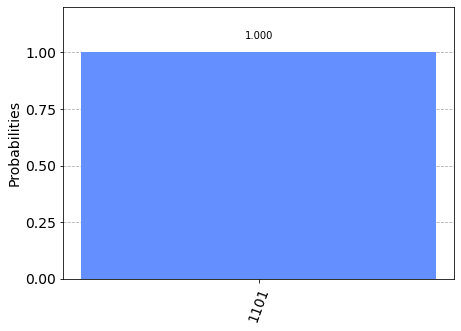

In [8]:
plot_histogram(runAer(dj))

least busy backend:  ibmq_lima
Job Status: job has successfully run


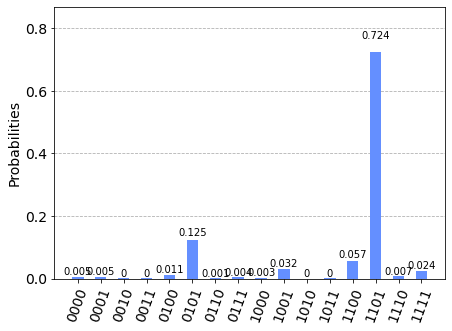

In [9]:
plot_histogram(runReal(dj,n+1))

It can be noted that the 1101 state for both the real and the simulator has the maximum amplitude.